# Determine the attributes of a successful post on r/askscience

**Definition**: We define a successful post as the one that have high score, and thus had received high attention by the Reddit community. 

- If prediction is possible, what features are useful in prediction? 
- What type of comments drive discussions on social media?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import re
import spacy
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Load Dataset
    - The duplicates are rarely all the same. They are normally only different by score. Let’s eliminate all entries with duplicate titles.


In [2]:
df = pd.read_csv('/Users/daniellelopes/Downloads/askscience_data.csv', index_col=0)
print('Shape of the original dataframe:', df.shape[0])
print(f"Dataframe has {df.duplicated(['title', 'body']).sum()} duplicated entries. Remove duplicates keeping only the ones with higest scores.")
df = df.sort_values(by='score').drop_duplicates(subset='title', keep='last').reset_index(drop=True)

print('Length of the dataframe after drop duplicates:', df.shape[0])

df.describe()

Shape of the original dataframe: 4205
Dataframe has 498 duplicated entries. Remove duplicates keeping only the ones with higest scores.
Length of the dataframe after drop duplicates: 3705


,score,upvote_ratio
count,3705.000000,3705.000000
mean,2889.799190,0.745652
std,5176.409839,0.179024
min,0.000000,0.170000
25%,3.000000,0.560000
50%,18.000000,0.800000
75%,6439.000000,0.910000
max,83382.000000,1.000000


## Let's use quantile .75 as our definition of successfull post.


In [3]:
df_success = df[df['score'] > df['score'].quantile(.75)]
print(f"{df_success.shape[0]} post has score > {df['score'].quantile(.75)}")

926 post has score > 6439.0


# Data Cleaning and pre-processing
- body and tag have NaN values. Fix it. 

In [4]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3705 entries, 0 to 3704
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3705 non-null   object 
 1   body          2490 non-null   object 
 2   tag           3511 non-null   object 
 3   datetime      3705 non-null   object 
 4   author        3705 non-null   object 
 5   score         3705 non-null   float64
 6   upvote_ratio  3705 non-null   float64
 7   url           3705 non-null   object 
dtypes: float64(2), object(6)
memory usage: 231.7+ KB
None


### Fix some issues in Tag names
- Empty tags should be converted to Unknown
- Special cases easy to spot we can fix quickly:
    - 'Linguistics' and '   Linguistics'
    - 'META' and 'Meta'
    - Earth Sciences and Biology Still duplicate, score a bit different. Also, since it is just one sample, Ill include it with the other earth sciences.

In [5]:
# Fill NaN values with 'Unknown'
df['tag'] = df['tag'].fillna('Unknown')
df['tag'] = df['tag'].str.lower().str.replace('[^\w\s]', '').astype(str)
df['tag'] = df['tag'].str.lower().str.replace(' ', '')
df['tag'] = df['tag'].str.lower().str.replace('earthsciencesandbiology', 'earthsciences').astype(str)


### Date column pre-processing
- Date might give us some clues on the visibility of the posting. Understanding the peak hours of activity on r/askscience and posting during those times can possibly maximize exposure.
    - Convert data format and categorize it. 

In [6]:

def categorize_hour(hour):
    if 0 <= hour < 4: return 'Late Night'
    elif 4 <= hour < 8: return 'Early Morning'
    elif 8 <= hour < 12: return 'Morning'
    elif 12 <= hour < 16: return 'Noon'
    elif 16 <= hour < 20: return 'Evening'
    else: return 'Night'
    
df['datetime'] = pd.to_datetime(df['datetime'])
df['epoch'] = (df['datetime'] - dt.datetime(1970,1,1)).dt.total_seconds()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['hour_category'] = df['hour'].apply(categorize_hour)

### Feature Engeineering 
- Categorize Score in 4 quantiles for vizuallization.
- "Evidence" and "sources" might be important in the context of askscience community for a post to receive an upvote - create a new feature to check if body has links. 
- Count number of characters in body and title columns

In [7]:
# Function to check for links
def has_link(text):
    if isinstance(text, str):  # Check if text is a string
        return bool(re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))
    else:
        return 2

# Create new column indicating if link exists
df['has_links'] = df['body'].apply(has_link)

# count number of characters
df['body_length'] = df['body'].str.len()
df['title_length'] = df['title'].str.len()

# categorize score
df['score_cat'] = pd.qcut(df['score'], q=4, labels=['Low', 'Medium', 'High', 'Highest'])

df.groupby('score_cat')['score'].agg(['count','mean', 'std', 'min', 'max'])



,count,mean,std,min,max
score_cat,,,,,
Low,1011,0.919881,1.089332,0.0,3.0
Medium,861,8.861789,3.936199,4.0,18.0
High,907,1254.535832,2025.177598,19.0,6439.0
Highest,926,10324.278618,5336.596114,6443.0,83382.0


## EDA - Histogram of Scores

- The average score is 2889. Half of the posts are low in popularity with a score < 18  
- Only 25% of posts have score > 6439
- 507 posts have 0 score

count     3705
mean      2889
std       5176
min          0
10%          0
25%          3
50%         18
75%       6439
90%       9572
max      83382
Name: score, dtype: int64
Number of posts with zero score: 507


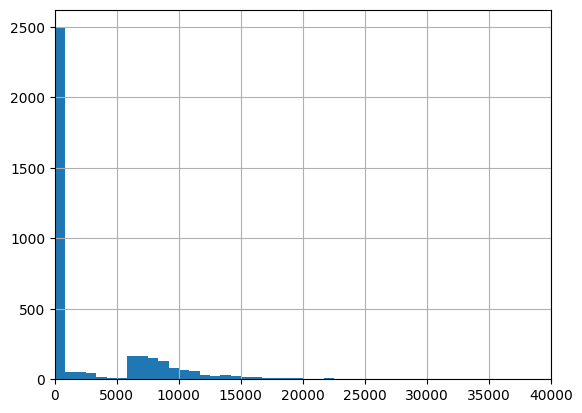

In [8]:
print(df['score'].describe(percentiles=[.1,.25, .5, .75,.9]).astype(int))
print('Number of posts with zero score:', (df['score']== 0).sum())
df['score'].hist(bins=100)
plt.xlim([0,40000])
plt.show()

## Correlation between numerical features
- Score and upvote_score are highly correlated - 0.51
- Score and has_link (feature created to check the existence of links/urls in the body feature), 'title_length', and 'body_length' also have positive correlation.
- Score and date features have a low negative correlation


,score,upvote_ratio,has_links,title_length,body_length,datetime,hour,year,month
score,1.000000,0.509968,0.213792,0.198058,0.082678,-0.142192,-0.104321,-0.143342,0.020360
upvote_ratio,0.509968,1.000000,0.157900,0.190139,0.086536,0.314132,-0.051765,0.313643,-0.019657
has_links,0.213792,0.157900,1.000000,0.240908,0.385030,-0.051465,-0.019694,-0.054587,0.034605
title_length,0.198058,0.190139,0.240908,1.000000,0.092189,-0.013259,-0.047934,-0.017647,0.041563
body_length,0.082678,0.086536,0.385030,0.092189,1.000000,0.033378,-0.054964,0.032841,0.001283
datetime,-0.142192,0.314132,-0.051465,-0.013259,0.033378,1.000000,0.054454,0.994602,-0.014920
hour,-0.104321,-0.051765,-0.019694,-0.047934,-0.054964,0.054454,1.000000,0.052508,0.014778
year,-0.143342,0.313643,-0.054587,-0.017647,0.032841,0.994602,0.052508,1.000000,-0.118312
month,0.020360,-0.019657,0.034605,0.041563,0.001283,-0.014920,0.014778,-0.118312,1.000000


Correlation Matrix for numerical features - Score, upvote_ratio and dates


<Axes: >

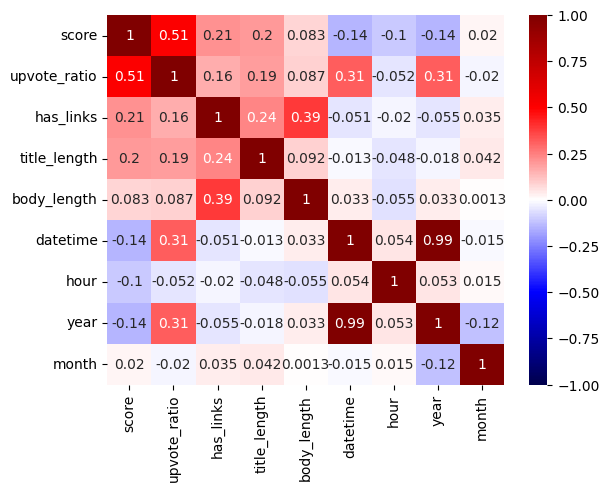

In [9]:
df_corr = df[[ 'score', 'upvote_ratio','has_links', 'title_length', 'body_length',
              'datetime', 'hour', 'year', 'month',  ]].corr()
display(df_corr)

print('Correlation Matrix for numerical features - Score, upvote_ratio and dates')
sns.heatmap(df_corr, cmap="seismic", annot=True, vmin=-1, vmax=1)

### Explore Dates closer - Does the time of the day impact the score?
- We can see some hours of the day with slightly higher score - morning and evening. Maybe it's because of the score algorithm that updates the value at regular intervals. 
- Some years seems to be more popular. 
- Apr, Aug, Nov, Dec present lower scores.

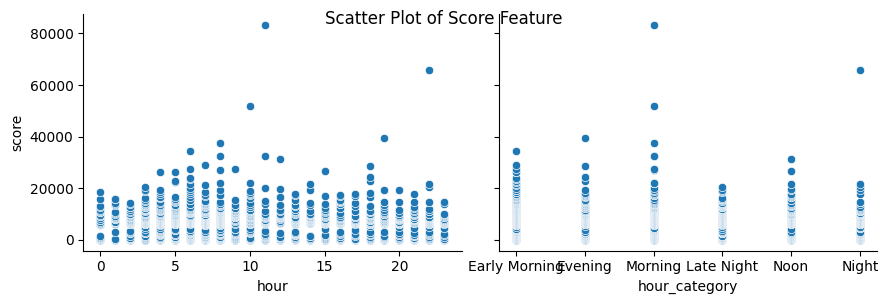

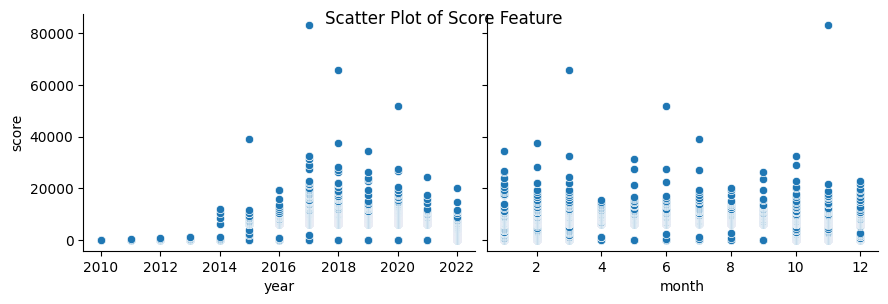

In [10]:
df_date = df[['score','hour', 'hour_category', 'year', 'month']]

sns.pairplot(df_date,y_vars = ['score'], x_vars=['hour', 'hour_category'],kind='scatter', height=3, aspect=1.5)
plt.suptitle('Scatter Plot of Score Feature')
plt.show()

sns.pairplot(df_date,y_vars = ['score'], x_vars=[ 'year', 'month'],kind='scatter', height=3, aspect=1.5)
plt.suptitle('Scatter Plot of Score Feature')
plt.show()


# EDA - Categorical features

## Feature: Author
- Feature author does not make large contributions. The vast majority of posts are written by different authors, with few exceptions, and therefore have little impact on our analysis.

In [11]:
# Feature author
df.author.value_counts()

author
DELETED                214
AskScienceModerator     47
inquilinekea            10
Gargatua13013            5
AsAChemicalEngineer      5
                      ... 
VegitoFusion             1
RealisticBar7194         1
theplushpairing          1
doctorofphysick          1
CTH2004                  1
Name: count, Length: 3308, dtype: int64

## Feature: has_links
- 18% of high score posts have links in it, and only 10% of low score posts have links. 

score_cat  has_links
Low        False        0.896277
           True         0.103723
Medium     False        0.928788
           True         0.071212
High       False        0.877023
           True         0.122977
Highest    False        0.823913
           True         0.176087
Name: proportion, dtype: float64


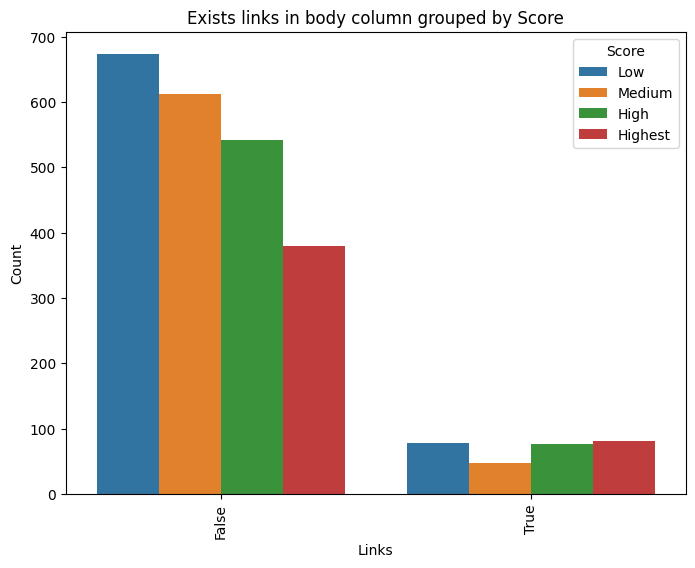

In [12]:
## vizualise tag 
tag_stats = df[df['has_links']<2].groupby('score_cat')['has_links'].value_counts(normalize=True)
print(tag_stats)
# Sort the DataFrame by mean grade in descending order
plt.figure(figsize=(8, 6))
sns.countplot(data=df[df['has_links']<2], x='has_links', hue='score_cat')
plt.title('Exists links in body column grouped by Score')
plt.xlabel('Links')
plt.ylabel('Count')
plt.legend(title='Score')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

## Feature: Tag
- Tags such as engineering, earthscience, and covid have high relative score. 
- Tags such as biology, physics and human body have high absolute score.
- Interesting to note that Tag unknown (missing data in column Tag) has low score values for most part. It might indicate that post and theme alignement is an important feature. We may want to consider it as a feature to predicting the score.

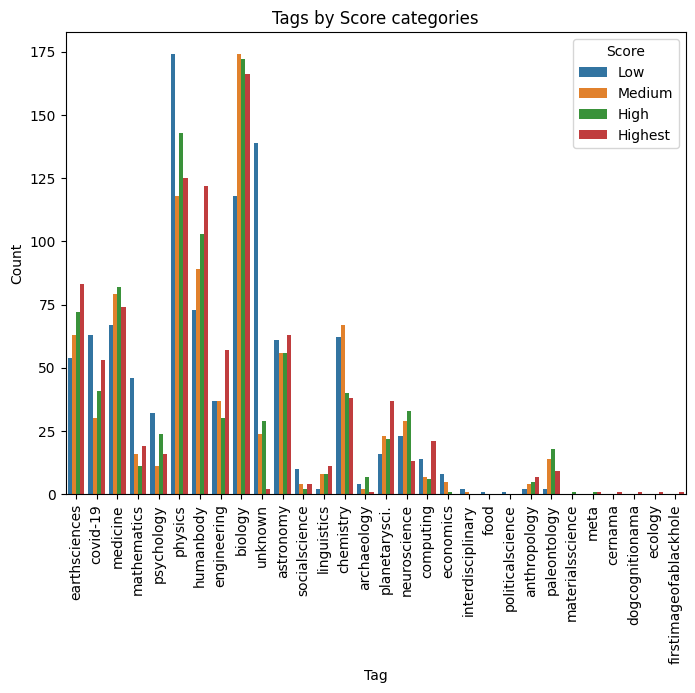

In [13]:
## vizualise tag 
tag_stats = df.groupby('score_cat')['tag'].value_counts()

# Sort the DataFrame by mean grade in descending order
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='tag', hue='score_cat')
plt.title('Tags by Score categories')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.legend(title='Score')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

### Feature: Tag - Average score values
- One can notice that some categories/tags that have very few posts, such as "meta", "cernama", "firstimageofablackhole", and "dogcognitionama" are very popular (high socore). This may indicates that novel topic, that is unique and that haven't been asked before may get more attention.

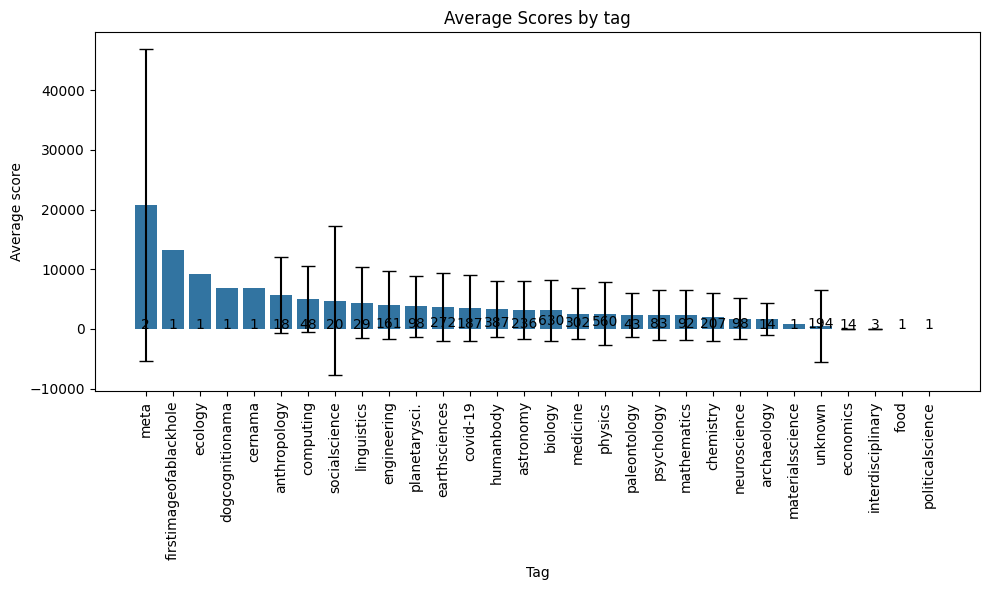

In [14]:
## vizualise tag 
def plot_scores_by_tag(tag_stats):
    # Sort the DataFrame by mean grade in descending order
    tag_stats = tag_stats.sort_values(by='mean', ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=tag_stats.index, y=tag_stats['mean'], errorbar='sd')
    plt.errorbar(x=tag_stats.index, y=tag_stats['mean'], yerr=tag_stats['std'], fmt='none', ecolor='black', capsize=5)

    for i, v in enumerate(tag_stats['count']):
        plt.text(i, v + 0.2, str(v), ha='center', va='baseline')

    plt.title('Average Scores by tag')
    plt.xlabel('Tag')
    plt.ylabel('Average score')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

tag_stats = df.groupby('tag')['score'].agg(['count','mean', 'std'])
plot_scores_by_tag(tag_stats)

## Feature: Tag in successful dataset
- Average score is greater as this dataset excludes zero score.

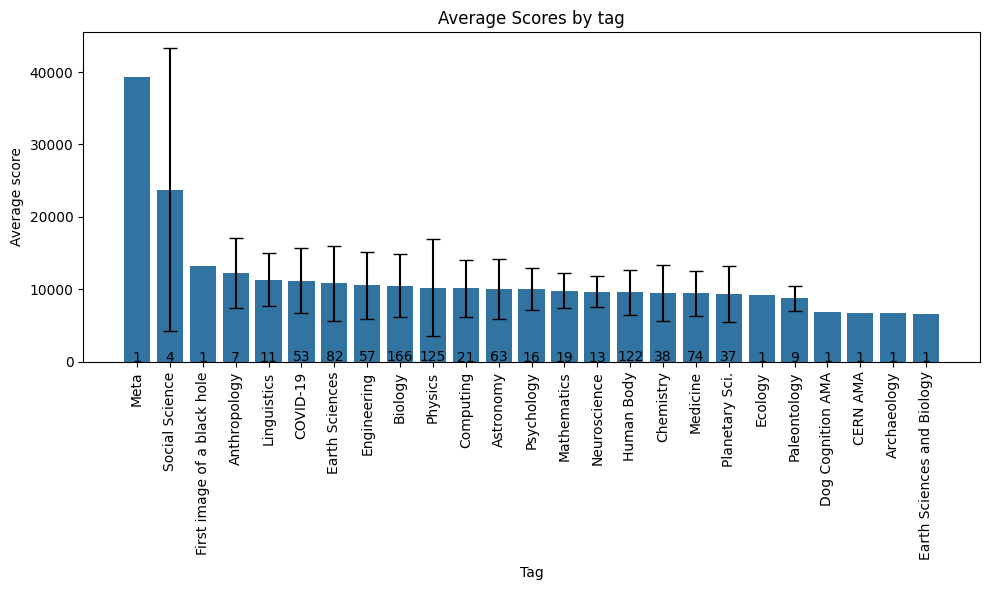

In [15]:
tag_stats = df_success.groupby('tag')['score'].agg(['count','mean', 'std'])
plot_scores_by_tag(tag_stats)


## Features - Number of missing values in body columns, and number of characters in title and body
- High score class has high number of missing data in feature body. It might indicate that posts that are more succint are more likely to attract readers. 
- Larger number of characters in title and body shows a tendency to produce higher score posts. Posts with some level of detail can make a post more appealing and easier to understand. 

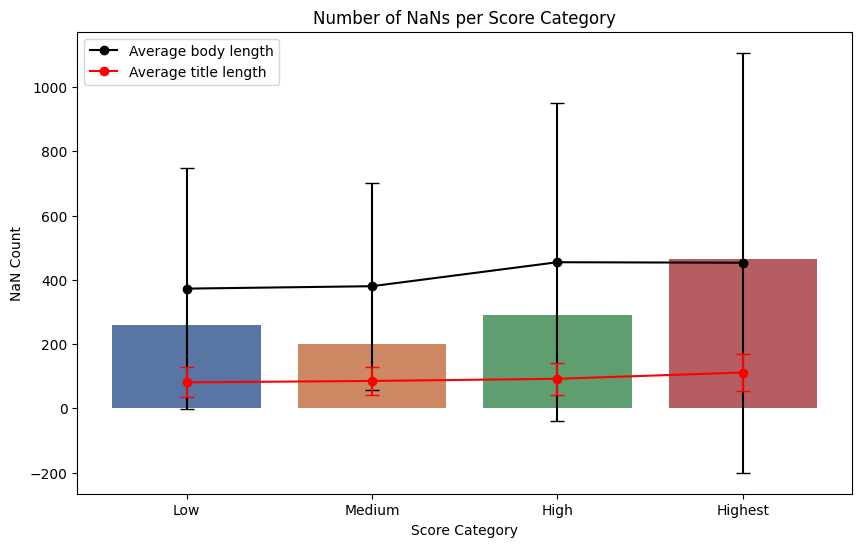

In [16]:
# Count the number of NaNs per category

nan_counts = df.groupby('score_cat')['body'].apply(lambda x: x.isnull().sum()).reset_index(name='nan_count')

# Plot the number of NaNs per category
plt.figure(figsize=(10, 6))
sns.barplot(x='score_cat', y='nan_count',hue='score_cat', data=nan_counts, palette='deep')
df_stats = df.dropna(subset=['body']).groupby('score_cat')['body_length'].agg(['mean','std'])
plt.plot(df_stats.index, df_stats['mean'], marker='o', color='black', linestyle='-', label='Average body length')
plt.errorbar(x=df_stats.index, y=df_stats['mean'], yerr=df_stats['std'], fmt='none', ecolor='black', capsize=5)


df_stats = df.groupby('score_cat')['title_length'].agg(['mean','std'])
plt.plot(df_stats.index, df_stats['mean'], marker='o', color='red', linestyle='-', label='Average title length')
plt.errorbar(x=df_stats.index, y=df_stats['mean'], yerr=df_stats['std'], fmt='none', ecolor='red', capsize=5)

plt.title('Number of NaNs per Score Category')
plt.xlabel('Score Category')
plt.ylabel('NaN Count')
plt.legend()
plt.show()


## The text itself - Features Title and Body
- Word map of most commonly used words from title and body columns.


In [17]:
# First lets run some data cleaning to consider only relevant words by remove stopwords. 
# The data cleaning will be also important to the training model phase.

# Set of stopwords
stop_words = set(stopwords.words('english'))
#punctuation = set(string.punctuation)

# Function to remove stopwords and search for the word
def remove_stopwords(text):
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Join the filtered words back into a string
    return ' '.join(filtered_words)

# Load the English model in spaCy
nlp = spacy.load('en_core_web_sm')
# Function for lemmatization using spaCy
def lemmatize_text(text):
    # Tokenize the text and apply lemmatization
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    # Join the lemmatized words back into a string
    return ' '.join(lemmatized_words)

# Combine title and body in one column. 
df['title_body'] = df['title'] + ' ' + df['body'].fillna('')
# Remove stopwords 
df['title_body_no_stop_words'] = df['title_body'].apply(remove_stopwords)
# Apply lemmatization
df['title_body_Lemmatized'] = df['title_body_no_stop_words'].apply(lemmatize_text)

In [18]:
## Find the most common words 
# tf–idf is the product of two statistics, term frequency and inverse document frequency. There are various ways for determining the exact values of both statistics. A formula that aims to define the importance of a keyword or phrase within a document or a web page
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit-transform the text data to calculate TF-IDF scores
tfidf_matrix = tfidf_vectorizer.fit_transform(df['title_body_no_stop_words'])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to display TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)


### Word Cloud of TF-IDF Scores - Entire dataset

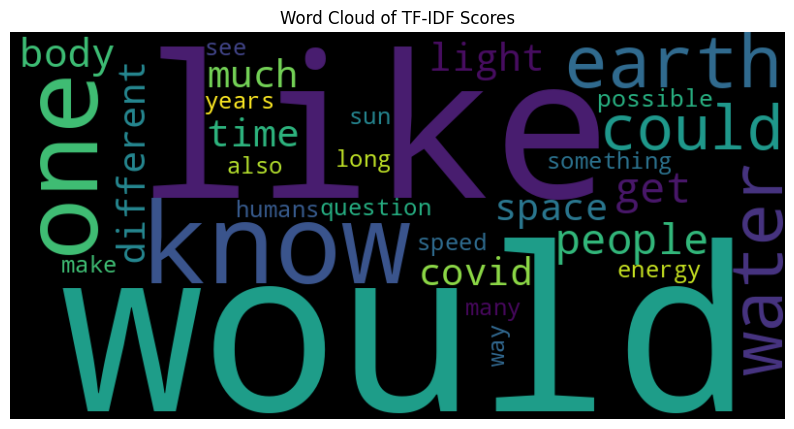

In [19]:
N = 100
top_words = tfidf_df.mean().sort_values(ascending=False).head(N)
top_words.index
# Convert TF-IDF scores into a dictionary
word_tfidf_scores =  dict(zip(top_words.index, top_words.values))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400,max_words=30, background_color='black').generate_from_frequencies(word_tfidf_scores)
# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Scores')
plt.show()


In [20]:
# Counting occurrences of words in text
def count_words_occurrences(text):
    words_to_count = top_words.index
    return sum(text.lower().count(word.lower()) for word in words_to_count)

df['most_important_words_Count'] = df['title_body_no_stop_words'].apply(count_words_occurrences)


<Axes: >

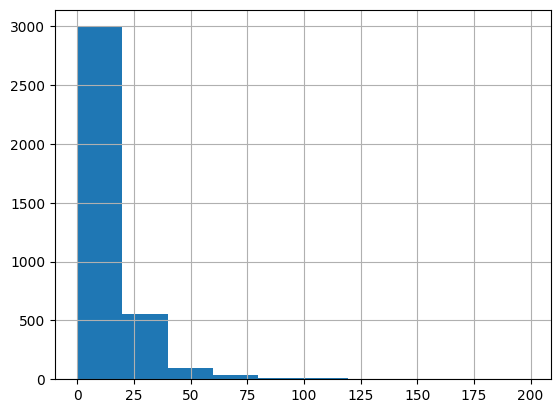

In [21]:
df['most_important_words_Count'].hist()

In [22]:
#df.to_csv('askscience_data_new_features.csv')

# Conclusion: 
### Definition: A successful post is the one that have high score, and thus had received high attention by the Reddit-askscience community. 
## Goal: Determine which posts and what content receive high attention.
- If prediction is possible, what features are useful in prediction? 
    -  From the EDA it seems that in addition to the text features "title" and "body", features "tag" and "upvote_ratio" also have high importance to predict the score. Engineered features - "body_length", "title_length", and "has_links" also showed high correlation with score.     
- What type of titles/post drive discussions on askcience?
    - word cloud figure shows the most import words in the text. Words related to science and knowlodge, such as "would", "like", and "know"(from "would like to know"), "space", "humans", "sun", "covid", "earth", etc., are more important in the context of the community, as expected.    
In summary, a successful post in this community needs to be specific about the science subject, have a relatively long title and body, a tag that adheres to the question topic, as well as evidence and information about its source.